# BEST:
# BEST METHOD KEEP THIS:

In [2014]:
import numpy as np
import sympy as sp
from typing import List, Tuple, Dict, Any, Set
from scipy.stats import levy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

class all_parameter_generation:
    """
    Generate state transitions and random parameters (a, b, c, enzyme) for an n-site phosphorylation model.

    Args:
        n: number of sites (int)
        distribution: distribution name ("gamma" supported)
        params: parameters for the distribution (for gamma: [shape, scale])
        verbose: if True, prints transitions and matrices
    """
    def __init__(self, n: int, reaction_types: str, distribution: str, distribution_paramaters: List[float], verbose: bool = False):
        self.n = n
        self.num_states = 2 ** n
        self.distribution = distribution
        self.params = distribution_paramaters
        self.reaction_types = reaction_types
        self.verbose = verbose
        self.rng = np.random.default_rng()
        
    @staticmethod
    def padded_binary(i: int, n: int) -> str:
        return bin(i)[2:].zfill(n)

    @staticmethod
    def binary_string_to_array(string: str) -> np.ndarray:
        return np.array([int(i) for i in string], dtype=int)

    def calculate_valid_transitions(self) -> Tuple[List[List[Any]], List[List[Any]]]:
        """
        Returns:
            valid_X_reactions: list of [state_i_str, state_j_str, i, j, "E"]
            valid_Y_reactions: list of [state_i_str, state_j_str, i, j, "F"]
        """
        all_states = [self.padded_binary(i, self.n) for i in range(self.num_states)]

        valid_difference_vectors: Set[Tuple[int, ...]] = set()
        valid_X_reactions: List[List[Any]] = []
        valid_Y_reactions: List[List[Any]] = []

        for i in range(self.num_states):
            arr_i = self.binary_string_to_array(all_states[i])
            for j in range(self.num_states):
                if i == j:
                    continue
                arr_j = self.binary_string_to_array(all_states[j])
                diff = arr_j - arr_i
                # if self.reaction_types == "distributive":
                    
                hamming_weight = np.sum(np.abs(diff))

                if hamming_weight == 1:
                    # +1 -> phosphorylation (E), -1 -> dephosphorylation (F)
                    element = "E" if np.any(diff == 1) else "F"
                    if element == "E":
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (E), {i}, {j}")
                        valid_X_reactions.append([all_states[i], all_states[j], i, j, element])
                    else:
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (F), {i}, {j}")
                        valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])
                    valid_difference_vectors.add(tuple(diff))

        return valid_X_reactions, valid_Y_reactions
    
    def alpha_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params

        alpha_matrix = np.zeros((self.num_states, self.num_states))

        for _, _, i, j, _ in valid_X_reactions:

            alpha_matrix[i][j] = self.rng.gamma(shape, scale)

        return alpha_matrix

    def beta_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params
        beta_matrix = np.zeros((self.num_states, self.num_states))
        
        for _, _, i, j, _ in valid_Y_reactions:

            beta_matrix[i][j] = self.rng.gamma(shape, scale)

        return beta_matrix
    
    def k_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for a_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            k_positive_rates = self.rng.gamma(shape, scale, self.num_states - 1)
            k_negative_rates = self.rng.gamma(shape, scale, self.num_states - 1)
        if self.distribution == "levy":
            k_positive_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
            k_negative_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
        # k_positive_rates[-1] = 0
        # k_negative_rates[-1] = 0
        
        return k_positive_rates, k_negative_rates

    def p_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for b_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            p_positive_rates = self.rng.gamma(shape, scale, self.num_states - 1)
            p_negative_rates = self.rng.gamma(shape, scale, self.num_states - 1)
        if self.distribution == "levy":
            p_positive_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
            p_negative_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
        # p_positive_rates[0] = 0
        # p_negative_rates[0] = 0

        return p_positive_rates, p_negative_rates

In [ ]:
def MATTIA_FULL(t, state_array, n, Kp, Pp, G, H, Q, M_mat, D, N_mat):

    ones_vec = np.ones(2**n - 1)
    
    # assert len(state_array) == 3*N
    # print(state_array)
    a = state_array[0: 2**n]
    b = state_array[2**n: 2*2**n - 1]
    c = state_array[2*2**n - 1: 3*2**n - 2]
    x = float(state_array[-2])
    y = float(state_array[-1])

    a_dot = (G @ b) + (H @ c) - x * (Kp @ a) - y * (Pp @ a)  
    b_dot = x * (Q @ a) - (M_mat @ b)
    c_dot = y * (D @ a) - (N_mat @ c)

    x_dot = -1*ones_vec.T @ b_dot
    y_dot = -1*ones_vec.T @ c_dot

    return np.concatenate((a_dot, b_dot, c_dot, np.array([x_dot, y_dot])))

# def jacobian_reduced(t, state_array, n, x_tot, y_tot, L1, L2, W1, W2):
#     N = 2**n
#     ones_vec_j = np.ones(N - 1)
#     # a_fixed_points = np.array(a_fixed_points).reshape((N, 1))  # shape (N, 1)
#     a = state_array[0: N].astype(float)

#     # L1 = np.array(L1, dtype=float)
#     # L2 = np.array(L2, dtype=float)
#     # W1 = np.array(W1, dtype=float)
#     # W2 = np.array(W2, dtype=float)

#     # Compute denominators
#     denom1 = 1 + float(ones_vec_j @ (W1 @ a))
#     denom2 = 1 + float(ones_vec_j @ (W2 @ a))

#     # Compute terms
#     term1 = (L1 / denom1) - np.outer(L1 @ a, ones_vec_j @ W1) / (denom1**2)
#     term2 = (L2 / denom2) - np.outer(L2 @ a, ones_vec_j @ W2) / (denom2**2)
#     return (x_tot / y_tot) * term1 + term2

def MATTIA_REDUCED(t, state_array, n, x_tot, y_tot, L1, L2, W1, W2):

    N = 2**n
    ones_vec = np.ones(N - 1)

    # assert len(state_array) == N

    a = state_array[0: N].astype(float)

    ###### PSEUDO-STEADY STATE APPROXIMATION IS MADE HERE, BUT ODE IS NOT DIMENSIONLESS
    a_dot = ((x_tot * L1 @ a) / (1 + ones_vec @ W1 @ a)) + (y_tot * (L2 @ a) / (1 + ones_vec @ W2 @ a)) 

    return a_dot

def MATRIX_FINDER(n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates):

    ones_vec = np.ones(2**n - 1)

    Kp = np.diag(np.append(k_positive_rates, 0))
    Km = np.append(np.diag(k_negative_rates), np.zeros((1, len(k_negative_rates))), axis=0)

    Pp = np.diag(np.insert(p_positive_rates, 0, 0))
    Pm = np.vstack([np.zeros((1, len(p_negative_rates))), np.diag(p_negative_rates)])    # print("a", a)

    adjusted_alpha_mat = np.delete(alpha_matrix, -1, axis = 0)
    adjusted_beta_mat = np.delete(beta_matrix, 0, axis = 0)

    Da = np.diag(alpha_matrix[:-1, 1:] @ ones_vec)
    Db = np.diag(beta_matrix[1:, :-1] @ ones_vec)

    U = np.diag(k_negative_rates)
    I = np.diag(p_negative_rates)
    Q = Kp[:-1, :]
    D = np.delete(Pp, 0, axis=0)

    M_mat = U + Da
    N_mat = I + Db

    G = Km + adjusted_alpha_mat.T
    H = Pm + adjusted_beta_mat.T

    # U, s, Vt = np.linalg.svd(M)
    # M_inv = (Vt.T * np.linalg.inv(S)) @ U.T
    # U, s, Vt = np.linalg.svd(N)
    # N_inv = (Vt.T * np.linalg.inv(S)) @ U.T

    M_inv = np.linalg.inv(M_mat); N_inv = np.linalg.inv(N_mat)

    L1 = G @ M_inv @ Q - Kp; L2 = H @ N_inv @ D - Pp
    W1 = M_inv @ Q; W2 = N_inv @ D

    return Kp, Pp, G, H, Q, M_mat, D, N_mat, L1, L2, W1, W2

def phosphorylation_system_solver(parameters_tuple, initial_states_array, final_t, full_model):

    n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot, x_tot, y_tot = parameters_tuple
    N = 2**n

    assert np.all(initial_states_array <= (a_tot + 1e-12))
    # assert np.all(initial_states_array >= 0)
    # assert np.all(initial_states_array <= a_tot)

    #### SCALING TIME
    initial_t = 0
    # final_t = 2000
    t_span = (initial_t, final_t)

    ###### OBTAINING ALL MATRICES
    Kp, Pp, G, H, Q, M_mat, D, N_mat, L1, L2, W1, W2 = MATRIX_FINDER(n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)
    cmap = plt.get_cmap('tab10')
    def color_for_species(idx):
        return cmap(idx % cmap.N)
    
    plt.figure(figsize = (8, 6))
    plt.style.use('seaborn-v0_8-whitegrid')

    abstol = 1e-20
    reltol = 1e-5
    if full_model == False:
        assert len(initial_states_array) == N

        mattia_reduced_parameter_tuple = (n, x_tot, y_tot, L1, L2, W1, W2)
        # t_array = np.linspace(t_span[0], t_span[1], 500)
        sol = solve_ivp(MATTIA_REDUCED, t_span = t_span, y0=np.asarray(initial_states_array, dtype=float), 
                        args = mattia_reduced_parameter_tuple, method = 'LSODA', atol = abstol, rtol = reltol)
        # jac = jacobian_reduced
        a_solution_stack = np.stack([sol.y[i] for i in range(0, N)]) / a_tot

        for i in range(a_solution_stack.shape[0]):
            color = color_for_species(i)
            plt.plot(sol.t, a_solution_stack[i], color=color, label = f"[$A_{i}]$", lw=4, alpha = 0.4)
            print(f"final A_{i} = {a_solution_stack[i][-1]}")
            plt.title(f"Plotting reduced phosphorylation dynamics for n = {n}")

    if full_model == True:
        assert len(initial_states_array) == 3*N
        # assert np.all(initial_states_array >= 1e-15)
        assert np.all(initial_states_array >= 0)

        mattia_parameter_tuple = (n, Kp, Pp, G, H, Q, M_mat, D, N_mat)
        # t_array = np.linspace(t_span[0], t_span[1], 500)
        sol = solve_ivp(MATTIA_FULL, t_span = t_span, y0=np.asarray(initial_states_array, dtype=float), 
                        args = mattia_parameter_tuple, method = 'LSODA', atol = abstol, rtol = reltol)

        a_solution_stack = np.stack([sol.y[i] for i in range(0, N)]) / a_tot
        # b_solution_stack = np.stack([sol.y[i] for i in range(N, 2*N - 1)]) 
        # c_solution_stack = np.stack([sol.y[i] for i in range(2*N - 1, 3*N - 2)]) 
        # x_solution = sol.y[-2]
        # y_solution = sol.y[-1]
        # for i in range(b_solution_stack.shape[0]):
        #     color = color_for_species(i + a_solution_stack.shape[0])
        #     plt.plot(sol.t, b_solution_stack[i], color=color, label = f"$B_{i}$", lw=1.5, linestyle='-', alpha = 0.75)
        #     print(f"final B_{i} = {b_solution_stack[i][-1]}")

        # for i in range(c_solution_stack.shape[0]):
        #     color = color_for_species(i + a_solution_stack.shape[0] + b_solution_stack.shape[0] - 1)
        #     plt.plot(sol.t, c_solution_stack[i], color=color, label=f"$C_{i+1}$", lw=1, linestyle='--', alpha = 1)
        #     print(f"final C_{i+1} = {c_solution_stack[i][-1]}")

        # print(f"final X = {x_solution[-1]}")
        # print(f"final Y = {y_solution[-1]}")
        # print(a_solution_stack)

        for i in range(a_solution_stack.shape[0]):
            color = color_for_species(i)
            plt.plot(sol.t, a_solution_stack[i], color=color, label = f"$[A_{i}]$", lw=4, alpha = 0.4)
            print(f"final numerical fp of A_{i}: {a_solution_stack[i][-1]}")
            plt.title(f"full system dynamics for n = {n}")
        # plt.plot(sol.t, x_solution, color='black', label="$X$", lw=1.75, alpha = 0.75)
        # plt.plot(sol.t, y_solution, color='gray', label="$Y$", lw=1, alpha = 0.75)
    # plt.figure(figsize = (8, 6))
    plt.ylabel("concentration")
    plt.xlabel("time")
    plt.minorticks_on()
    plt.tight_layout()
    plt.xlim(t_span[0] - 0.1, t_span[1] + 0.1)
    plt.ylim(-0.05, 1.1)
    plt.legend(frameon=False)
    plt.show()
    
    # from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
    # fig = plt.figure(figsize = (8, 6))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot(a_solution_stack[0], a_solution_stack[2], a_solution_stack[3], color='blue', linewidth=2)
    # plt.show()
    # plt.figure(figsize = (8, 6))
    # plt.style.use('seaborn-v0_8-whitegrid')
    # plt.scatter(a_solution_stack[0][0], a_solution_stack[3][0], c = 'r', label = "IC")
    # plt.plot(a_solution_stack[0], a_solution_stack[3], 'k', lw=4, alpha = 0.4)
    # plt.xlabel("$A_0$")
    # plt.ylabel("$A_1$")
    # plt.title(f"phase portrait of full system dynamics for n = {n}")
    # plt.minorticks_on()
    # plt.xlim(-0.05, 1.1)
    # plt.ylim(-0.05, 1.1)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
        # plt.title(f"Plotting full phosphorylation dynamics for n = {n}")
        # # plt.plot(sol.t, x_solution, color='black', label="$X$", lw=1.75, alpha = 0.75)
        # # plt.plot(sol.t, y_solution, color='gray', label="$Y$", lw=1, alpha = 0.75)
        # plt.ylabel("concentration")
        # plt.xlabel("time (s)")
        # plt.minorticks_on()
        # plt.tight_layout()
        # plt.xlim(t_span[0] - 1, t_span[1] + 1)
        # plt.ylim()
        # plt.legend(frameon=False)
        # plt.show()

    # WRITE CODE THAT EXPORTS DATA AS FILE

def divergence_tester(state_array, n, x_tot, y_tot, L1, L2, W1, W2):
    N = 2**n
    # ones_vec_j = np.ones(N - 1)
    ones_vec_j = np.ones((1, N-1), dtype = float)
    # a = np.array(state_array).reshape((N, 1))  
    # a = state_array[0: N].astype(float)

    a = np.asarray(state_array, dtype=float).ravel()
    a = a.reshape((N, 1))
    a[-1] = 1 - np.sum(a)
    # denom1 = 1 + float(ones_vec_j @ (W1 @ a))
    # denom2 = 1 + float(ones_vec_j @ (W2 @ a))

    denom1 = float(1.0 + np.dot(ones_vec_j, (W1 @ a)).item())
    denom2 = float(1.0 + np.dot(ones_vec_j, (W2 @ a)).item())

    term1 = (L1 / denom1) - (((L1 @ a) @ (ones_vec_j @ W1)) / (denom1**2))
    term2 = (L2 / denom2) - (((L2 @ a) @ (ones_vec_j @ W2)) / (denom2**2))

    divergence = np.trace(((x_tot / y_tot) * term1) + term2)

    return divergence

In [ ]:
# t = np.array([0.99, 0, 0, 0.01])
t = np.random.rand(4)
print(t)
t[-1] = 1 - np.sum(t[0:-1])
print(t)

[0.37867578 0.53176321 0.70944626 0.30037017]
[ 0.37867578  0.53176321  0.70944626 -0.61988526]


# of stable states is 1
# of unstable states is 1
Divergence at this point is: -221031732.88457626
final A_0 = 3.969392727884612e-09
final A_1 = 0.00020786334114529414
final A_2 = 3.5208852473278855e-11
final A_3 = 5.366928735513756e-08
final A_4 = 0.016041884608969322
final A_5 = 0.027597036770285
final A_6 = 4.9537580678166535e-08
final A_7 = 3.206489402757284e-05
final A_8 = 3.925643070684939e-12
final A_9 = 5.4006412119304623e-08
final A_10 = 1.6491455481451854e-12
final A_11 = 0.5901143960755055
final A_12 = 0.13345033848371396
final A_13 = 0.02229223153586634
final A_14 = 0.04098999171835742
final A_15 = 0.16927403134034924


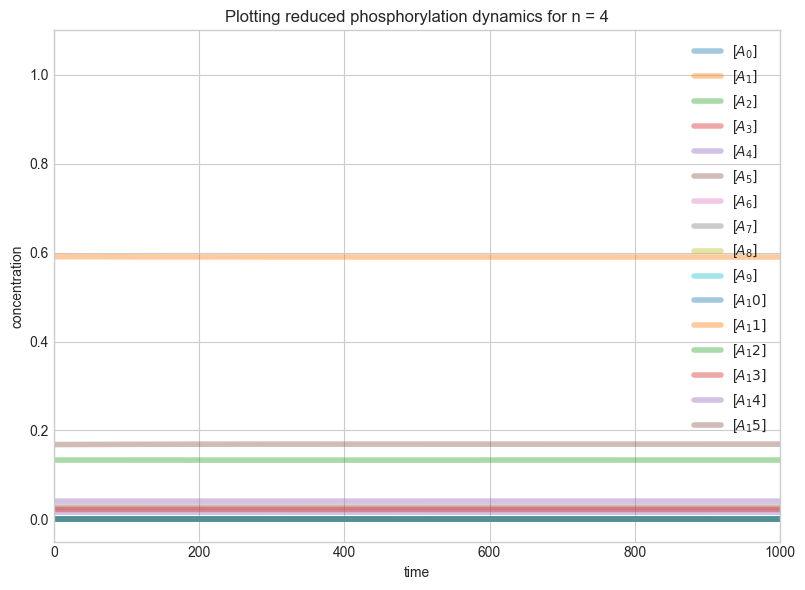

In [ ]:
import numpy as np
import pickle
import random

def plotter(full_model_bool, index, final_t, file_name):
    n = int(file_name[-5:-4])
    N = 2**n

    if file_name[0:14] == 'multistability':
        with open(file_name, "rb") as f:
            multistable_results = pickle.load(f)
        # print(len(multistable_results))
        # if multistable_results:
        #     example = monostable_results[0]
        #     for key, val in example.items():
        #         print(f"{key}: shape={getattr(val, 'shape', None)} type={type(val)}")
        a_stable_states = multistable_results[index]["stable_states"]
        a_unstable_states = multistable_results[index]["unstable_states"]
        num_stable_states = multistable_results[index]["num_of_stable_states"]
        num_unstable_states = multistable_results[index]["num_of_unstable_states"]
        a_tot_parameter = multistable_results[index]["total_concentration_values"][0]
        x_tot_parameter = multistable_results[index]["total_concentration_values"][1]
        y_tot_parameter = multistable_results[index]["total_concentration_values"][2]
        alpha_matrix = multistable_results[index]["alpha_matrix"]
        beta_matrix = multistable_results[index]["beta_matrix"]
        k_positive_rates = multistable_results[index]["k_positive"]
        k_negative_rates = multistable_results[index]["k_negative"]
        p_positive_rates = multistable_results[index]["p_positive"]
        p_negative_rates = multistable_results[index]["p_negative"]
        print(f"# of stable states is {num_stable_states}")
        print(f"# of unstable states is {num_unstable_states}")
        # a_stable_states = np.ravel(a_stable_states)*a_tot_parameter

        subindex = np.random.randint(0, num_unstable_states)
        a_unstable_states = np.ravel(a_unstable_states[subindex])*a_tot_parameter
        a_stable_states = np.ravel(a_stable_states[subindex])*a_tot_parameter
        # print("unstable state:", a_unstable_states)
        a_init_conditions_reduced = a_unstable_states
        # a_init_conditions_reduced = a_unstable_states

        # jacobian_point = 

        # a_init_conditions_full = a_stable_states[subindex].reshape((N, 1))
        # print(a_init_conditions_reduced)
        def pertubation_array_creation(ic_array, pertubation_parameter, plus):
            # find the 2 indices with the largest elements, create a pertubation array
            largest_index = np.argsort(ic_array)[-2:][-2]
            second_largest_index = np.argsort(ic_array)[-2:][-1]
            if plus:
                return np.array([pertubation_parameter if i == largest_index else -pertubation_parameter if i == second_largest_index else 0 for i in range(len(ic_array))])
            else: 
                return np.array([-pertubation_parameter if i == largest_index else pertubation_parameter if i == second_largest_index else 0 for i in range(len(ic_array))])
            
        pertubation_parameter = 0.001

        # jacobian_initial_condition = -100000*np.ones(N)
        # jacobian_initial_condition = jacobian_initial_condition / np.sum(jacobian_initial_condition)


        Kp, Pp, G, H, Q, M_mat, D, N_mat, L1, L2, W1, W2 = MATRIX_FINDER(n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)

        a_init_conditions_reduced[-1] = 1 - np.sum(a_init_conditions_reduced[0:-1])
        # print(jacobian_initial_condition)
        divergence_test = divergence_tester(a_init_conditions_reduced, n, x_tot_parameter, y_tot_parameter, L1, L2, W1, W2)
        print(f"Divergence at this point is: {divergence_test}")

        if full_model_bool == True:

            # if random.random() < 0.5:
            #     pertubation_array = pertubation_array_creation(a_init_conditions_full, pertubation_parameter, True)
            # else:
            #     pertubation_array = pertubation_array_creation(a_init_conditions_full, pertubation_parameter, False)
            # ones_vec = np.ones((1, N-1), dtype = float)


            # # a_init_conditions = a_stable_states
            # x_init_condition = x_tot_parameter / float(1.0 + np.dot(ones_vec, (W1 @ a_init_conditions_full)))
            # y_init_condition = y_tot_parameter / float(1.0 + np.dot(ones_vec, (W2 @ a_init_conditions_full)))

            # b_init_conditions = x_init_condition * (W1 @ a_init_conditions_full)
            # c_init_conditions = y_init_condition * (W2 @ a_init_conditions_full)
            # if random.random() < 0.5:
            #     pertubation_array[0] = -pertubation_parameter; pertubation_array[2] = pertubation_parameter
            # else:
            #     pertubation_array[0] = pertubation_parameter; pertubation_array[2] = -pertubation_parameter

            # initial_states_array_full_random = np.concatenate([np.ravel(a_init_conditions_full), np.ravel(b_init_conditions), np.ravel(c_init_conditions), np.ravel(x_init_condition), np.ravel(y_init_condition)]).astype(float)
            # # print(len(initial_states_array_full_random))
            # pertubation_array = np.zeros(3*N); 
            # if random.random() < 0.5:
            #     pertubation_array = pertubation_array_creation(a_init_conditions_full, pertubation_parameter, True)
            # else:
            #     pertubation_array = pertubation_array_creation(a_init_conditions_full, pertubation_parameter, False)
            # initial_states_array_full_random = initial_states_array_full_random + pertubation_array
            # print("initial_states_array_full_random:", initial_states_array_full_random)
            A_0_rand = random.random()*a_tot_parameter; A_N_rand = 1 - A_0_rand
            initial_states_array_full_random = np.concatenate([[A_0_rand], np.zeros(N-2), [A_N_rand], np.zeros(2*N)])
            print(len(initial_states_array_full_random))
            parameters_tuple = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot_parameter, x_tot_parameter, y_tot_parameter)
            phosphorylation_system_solver(parameters_tuple, initial_states_array_full_random, final_t, full_model_bool)

        if full_model_bool == False:
            if random.random() < 0.5:
                pertubation_array = pertubation_array_creation(a_init_conditions_reduced, pertubation_parameter, True)
            else:
                pertubation_array = pertubation_array_creation(a_init_conditions_reduced, pertubation_parameter, False)
            # pertubation_array = np.zeros(N); pertubation_array[0] += 0.1; pertubation_array[N-1] += -0.1
            initial_states_array_reduced_random = a_init_conditions_reduced + pertubation_array

            # initial_states_array_reduced_random = np.random.rand(N)
            # initial_states_array_reduced_random = initial_states_array_reduced_random / np.sum(initial_states_array_reduced_random)

            # print(f"initial_states_array_random: {initial_states_array_reduced_random}")
            parameters_tuple = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot_parameter, x_tot_parameter, y_tot_parameter)
            phosphorylation_system_solver(parameters_tuple, initial_states_array_reduced_random, final_t, full_model_bool)

# file_name = "multistability_parameters_5000_2.pkl"
file_name = "multistability_parameters_1000_4.pkl"

index = 1
# subindex = 0
full_model_bool = False
final_t = 1000
plotter(full_model_bool, index, final_t, file_name)

In [ ]:
##################### constructing initial parameter vectors/matrices
# gen = all_parameter_generation(n, "distributive", "gamma", (0.5, 1), verbose = False)
# alpha_matrix = gen.alpha_parameter_generation()
# beta_matrix = gen.beta_parameter_generation()
# k_positive_rates, k_negative_rates = gen.k_parameter_generation()
# p_positive_rates, p_negative_rates = gen.p_parameter_generation()


####################
# ones_vec = np.ones(N)
# alpha_matrix = np.array([[0, 1, 1, 0],
#                         [0, 0, 0, 1],
#                         [0, 0, 0, 1],
#                         [0, 0, 0, 0]])
# beta_matrix = np.array([[0, 0, 0, 0],
#                         [1, 0, 0, 0],
#                         [1, 0, 0, 0],
#                         [0, 1, 1, 0]])
# k_positive_rates = np.array([1, 1, 1, 0])
# k_negative_rates = np.array([1, 1, 1, 0])
# p_positive_rates = np.array([0, 1, 1, 1])
# p_negative_rates = np.array([0, 1, 1, 1])
#################### constructing additional needed matrices

# k_positive_matrix = np.diag(k_positive_rates); k_negative_matrix = np.diag(k_negative_rates)
# p_positive_matrix = np.diag(p_positive_rates); p_negative_matrix = np.diag(p_negative_rates)
# diagonal_loss_alpha_matrix = np.diag(alpha_matrix @ ones_vec); diagonal_loss_beta_matrix = np.diag(beta_matrix @ ones_vec)

[0. 0. 0.]


In [ ]:


# def jacobian_full

In [ ]:
# if file_name[0:13] == 'monostability':
#     with open(file_name, "rb") as f:
#         monostable_results = pickle.load(f)
#     num_stable_states = monostable_results[index]["num_of_stable_states"]
#     a_stable_states = monostable_results[index]["stable_states"]
#     a_tot_parameter = monostable_results[index]["total_concentration_values"][0]
#     x_tot_parameter = monostable_results[index]["total_concentration_values"][1]
#     y_tot_parameter = monostable_results[index]["total_concentration_values"][2]
#     alpha_matrix = monostable_results[index]["alpha_matrix"]
#     beta_matrix = monostable_results[index]["beta_matrix"]
#     k_positive_rates = monostable_results[index]["k_positive"]
#     k_negative_rates = monostable_results[index]["k_negative"]
#     p_positive_rates = monostable_results[index]["p_positive"]
#     p_negative_rates = monostable_results[index]["p_negative"]

#     a_stable_states = np.ravel(a_stable_states)*a_tot_parameter
#     a_init_conditions = a_stable_states.reshape((N, 1))

#     print(f"# of stable states is {len(a_stable_states)}")

#     if full_model_bool == True:
#         ones_vec = np.ones((1, N-1), dtype = float)
#         Kp, Pp, G, H, Q, M_mat, D, N_mat, L1, L2, W1, W2 = MATRIX_FINDER(n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)

#         # a_init_conditions = a_stable_states
#         x_init_condition = x_tot_parameter / float(1.0 + np.dot(ones_vec, (W1 @ a_init_conditions)))
#         y_init_condition = y_tot_parameter / float(1.0 + np.dot(ones_vec, (W2 @ a_init_conditions)))

#         b_init_conditions = x_init_condition * (W1 @ a_init_conditions)
#         c_init_conditions = y_init_condition * (W2 @ a_init_conditions)
#         print("Simulating monostability in the full model:")
#         initial_states_array_full_random = np.concatenate([np.ravel(a_init_conditions), np.ravel(b_init_conditions), np.ravel(c_init_conditions), np.ravel(x_init_condition), np.ravel(y_init_condition)]).astype(float)

#         # pertubation = np.zeros(3*N); pertubation[0] = pertubation[0] - 0.1; pertubation[14] = pertubation[14] + 0.1
#         pertubation = np.zeros(3*N); pertubation[0] = pertubation[0] + 0.1; pertubation[N] = pertubation[N] - 0.1

#         initial_states_array_full_random = initial_states_array_full_random + pertubation
        

#         parameters_tuple = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot_parameter, x_tot_parameter, y_tot_parameter)
#         phosphorylation_system_solver(parameters_tuple, initial_states_array_full_random, final_t, full_model_bool)
#     if full_model_bool == False:
#         print("Simulating monostability in the reduced model:")
#         initial_states_array_reduced_random = np.insert(np.zeros(N - 1), 0, a_tot_parameter)
#         # initial_states_array_reduced_random = np.random.rand(N)
#         # initial_states_array_reduced_random = initial_states_array_reduced_random / np.sum(initial_states_array_reduced_random)
#         parameters_tuple = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot_parameter, x_tot_parameter, y_tot_parameter)
#         phosphorylation_system_solver(parameters_tuple, initial_states_array_reduced_random, final_t, full_model_bool)



In [ ]:
file_name = 'bistability_parameters_100_4.csv'
print(n)

4


In [2411]:
import pickle